In [332]:
%load_ext autoreload
%autoreload 2
from src.models.__init__ import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data exploration 
Reading the file and having a first look at the data:

         DATE        ABC        XYZ     RATIO       DIFF
0  2016-01-04  47.595426  73.253267  1.539082  25.657841
1  2016-01-05  47.878171  73.851865  1.542496  25.973693
2  2016-01-06  47.202725  72.730107  1.540803  25.527382
3  2016-01-07  45.946080  70.774909  1.540391  24.828829
4  2016-01-08  45.820415  70.615571  1.541138  24.795155


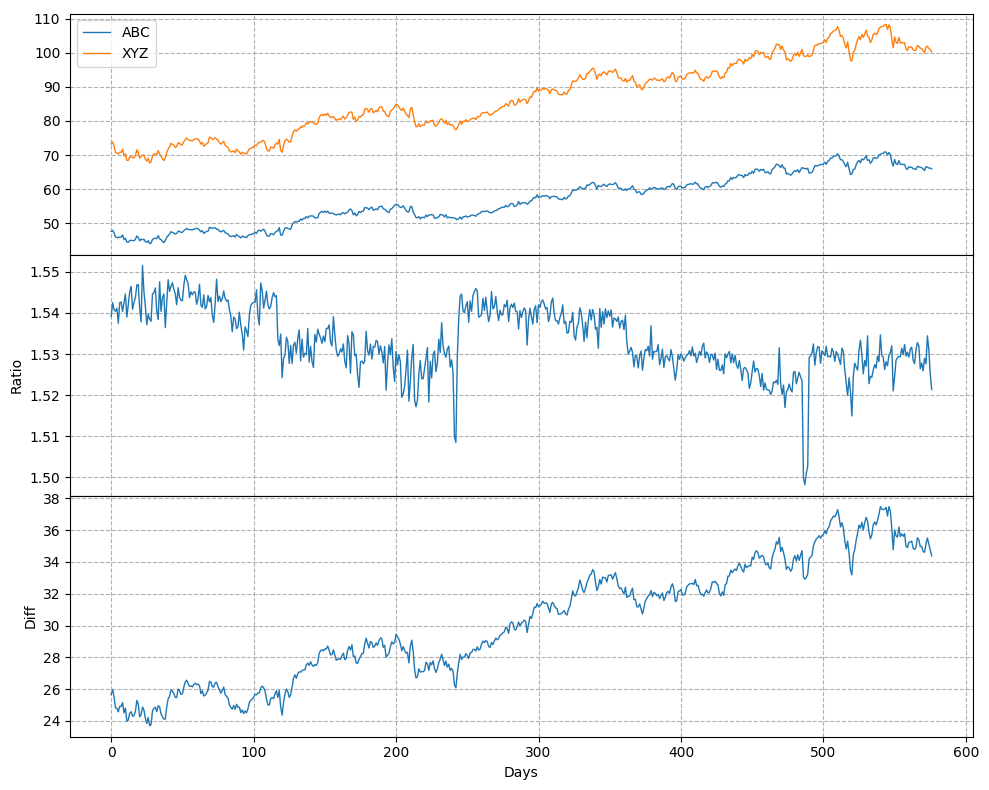

In [319]:
seriesFull = pd.read_csv('../data/raw/pairs.csv', header=0) 
print(seriesFull.head())

firstLook(seriesFull)

A rolling estimate of the mean and the mean +- its standard deviation are signals that can be used to decide when it might be a good time to enter or exit the market. Decided to use the ratio XYZ/ABC since the difference (XYZ-ABC) has a slope that would need to be subtracted if stationarity is used in any of the strategies.

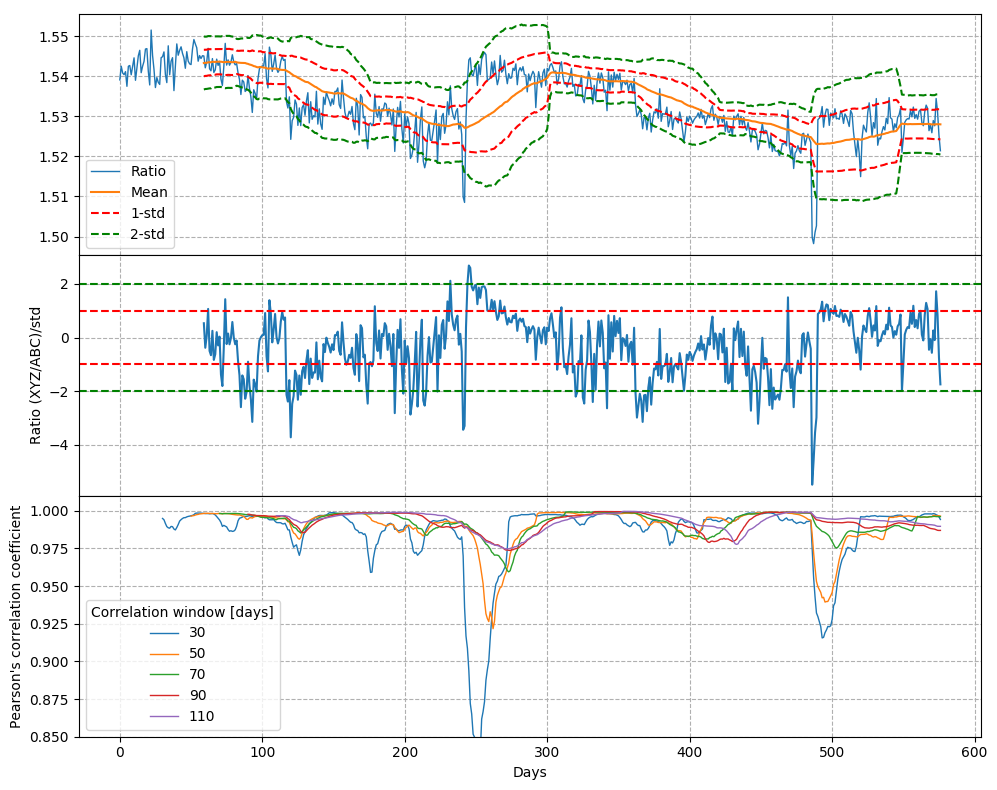

In [7]:
rollingEstimates(seriesFull, 60) # Using a 60-day rolling window

**Things to notice:**

- The rolling Pearson's coefficient is close to 1 over the whole range which indicates that the pair XYZ and ABC are truly correlated. 

- The scaled ratio is defined as the ratio XYZ/ABC divided by the standard deviation of the rolling mean. 

- "Recovery time" of the scaled ratio once it exceeds 1-std (or even 2-std) is of the order of days.

# Modeling
The data from 2016-01-04 to 2017-08-21 was randomly separated between train (70%) and validation data (30%). The train data was used to optimize parameters of a given algorithm.  The validation data was used to optimize hyper-parameters. 

The annualized rate of return (AR) was used as the metric to decide how good a strategy was. The AR was calculated by

$$AR = 100 \times \left(\prod_{i=1}^{N}(1+r_i)^{256/N} - 1 \right),$$

where $r_i$ is the return of day $i$ and $N$ is the total number of days. 

A Monte Carlo (MC) simulation with 10000 iterations was used to quantify the expected AR and risk for each strategy. In each MC iteration, an AR was calculated by randomly selecting (with replacement) the daily returns on the unseen data from 2017-08-22 to 2018-05-02 (test data) after applying a given strategy. The mean and standard deviation of the AR distribution correspond to the mean expected APR and associated risk of the strategy, respectively.

All transactions (buy or sell XYZ and ABC) are assumed to have no cost.

#### Comment about the code:
The machine learning algorithms used in this exercise are either native Scikit-Learn base estimator classes or have been written based on them. Two of the algorithms used (RNN and LSTM) used the tensorflow framework, and therefore two new classes, RNNClassifier and LSTMClassifier (Scikit-Learn compatible) were written. The multiple strategies were written using unique classes that rely heavily on parent inheritance. 

## Random strategy: 
This strategy defines entry and exit points at random points in time. An entry point is where a pair strategy selection is made (either long ABC, short XYZ or short ABC, long XYZ). An exit point corresponds to a position that is neutral. The positions are hedged only at the entry points (**not** continuosly hedged if the position is maintained). This decision was made since it is likely than in a real scenario there would be a transaction cost per transaction.  

In [327]:
random_str = randomStrategy()
random_str.apply()

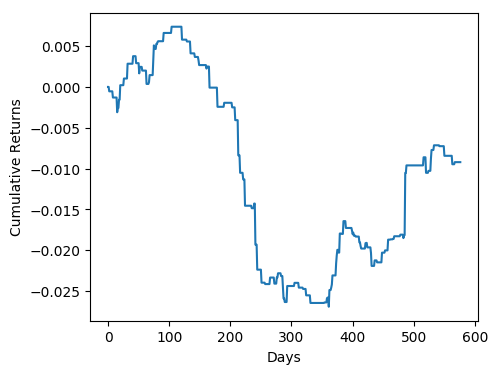

In [357]:
random_str.plot() 

As expected the final return is close to zero. Since it is a random strategy it is useful to obtain the results of larger sample:

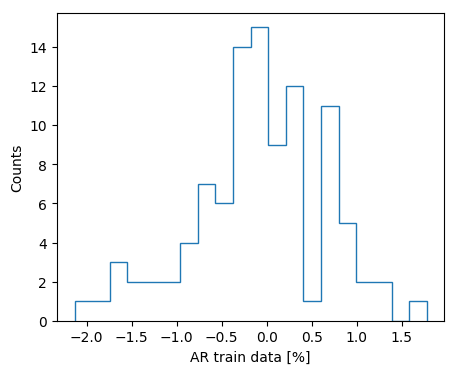

In [121]:
random_str.histogram()

Even though this is not a valid strategy, the above result indicates that unless a strategy is biased towards negative returns, a non-continuous hedging strategy (randomly wrong) is not expected to generate a negative AR lower than ~1%.   

## Threshold entry and exit strategy: 
This strategy defines entry and exit points based on how far the ratio XYZ/ABC is from its rolling mean. If the ratio is past a given entry threshold it is defined as an entry point. If the scaled ratio goes below a given exit threshold, it is defined as an exit point. The entry and exit thresholds, along with the rolling window range are hyper-parameters. The positions are hedged only at the entry points (**not** continuosly hedged). 

In [11]:
basic_str = basicStrategy()
basic_str.apply(50, 1, 0) # 50-day rolling window, 1-std entry point, 
                          # back to the mean for exit point

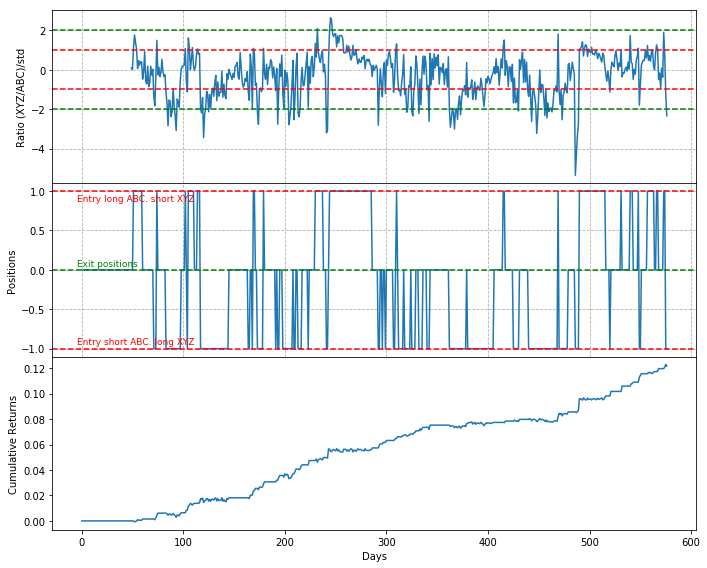

In [12]:
basic_str.plot()

The expected AR and associated risk of this strategy are:

Expected AR is 7.42% +- 2.55% (1-sigma confidence)


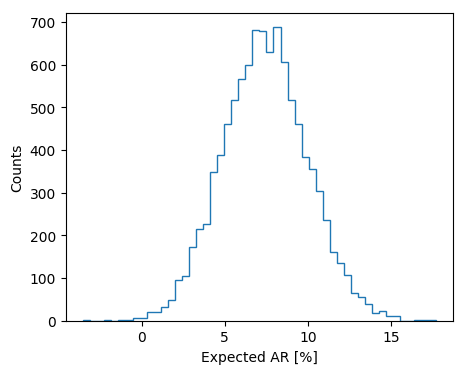

In [147]:
basic_str.ARdistribution()

The hyper-parameters of the strategy (window range for the rolling estimates, and entry and exits thresholds) were optimized used the full train data since there are no parameters: 

In [126]:
window = [2, 5, 10, 20, 30]
entry_threshold = [0.5, 0.75, 1, 1.5, 2]
exit_threshold = [0.25, 0, -0.25]
results = basic_str.optimization(window, entry_threshold, exit_threshold)

Best parameters: window range: 5 - entry: 0.5 - exit: 0 - AR: 12.37%


The best hyper-parameters are a 5-day rolling window, a 0.5 standard deviation entry threshold and an exit threshold of zero (when the scaled ratio goes back to the mean). The expected AR and risk of the strategy using the optmized hyper-parameters are:

Expected AR is 7.46% +- 2.58% (1-sigma confidence)


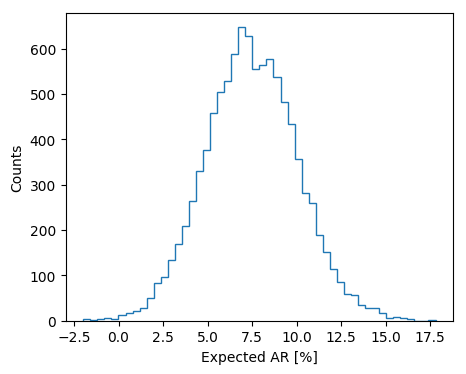

In [149]:
basic_str.apply(5, 0.5, 0) # Best result based on the train data 
basic_str.ARdistribution()

It is also instructive to understand the predictive power of the strategy (since this strategy does not have parameters but hyper-parameters) by plotting the AR of the train and test data for all the hyper-parameters studied:

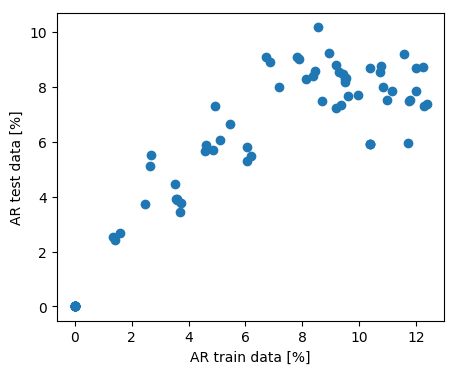

In [137]:
plotAR(results)

There is a correlation between the train and test data which indicates the strategy results on the train data have some predictive power over the strategy results on test data. 

## RNN ratio predicting strategy: 
This strategy defines entry and exit points based on Recurrent Neural Network (RNN) predictions on how the ratio XYZ/ABC will move next. 

### Recurrent Neural Network (RNN)
The RNN regression algorithm was trained to fit the ratio (XYZ/ABC)/std. Since the dataset is not very large, The RNN will consist of only 1-layer. The number of neurons and the number of sequences are hyper-parameters to be optimized. 

In [531]:
train_data = seriesFull.loc[:len(seriesFull)*0.7]
validation_data = seriesFull.loc[len(seriesFull)*0.7:]

rnn = RNNRegression(n_neurons=10, learning_rate=0.001, fit_range=50, 
                    rolling_window=10)
rnn.fit(train_data)

Iteration 0 - model RMSE:1.11244 - best RMSE:1.11244
Iteration 200 - model RMSE:0.95273 - best RMSE:0.95273
Iteration 400 - model RMSE:0.94645 - best RMSE:0.94645
Iteration 600 - model RMSE:0.92527 - best RMSE:0.92527
Iteration 800 - model RMSE:0.91341 - best RMSE:0.91341
Iteration 1000 - model RMSE:0.89867 - best RMSE:0.89867
Iteration 1200 - model RMSE:0.89090 - best RMSE:0.89090
Iteration 1400 - model RMSE:0.87839 - best RMSE:0.87839
Iteration 1600 - model RMSE:0.85764 - best RMSE:0.85764
Iteration 1800 - model RMSE:0.83656 - best RMSE:0.83656
Iteration 2000 - model RMSE:0.82123 - best RMSE:0.82123
Iteration 2200 - model RMSE:0.81498 - best RMSE:0.81498
Iteration 2400 - model RMSE:0.81322 - best RMSE:0.81322
Iteration 2600 - model RMSE:0.81216 - best RMSE:0.81216
Iteration 2800 - model RMSE:0.81330 - best RMSE:0.81216
Iteration 3000 - model RMSE:0.81279 - best RMSE:0.81216
Iteration 3200 - model RMSE:0.81317 - best RMSE:0.81216
Iteration 3400 - model RMSE:0.81390 - best RMSE:0.81216

RNNRegression(activation=<function elu at 0x133f13ae8>, fit_range=50,
       learning_rate=0.001, n_neurons=10,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       rolling_window=10)

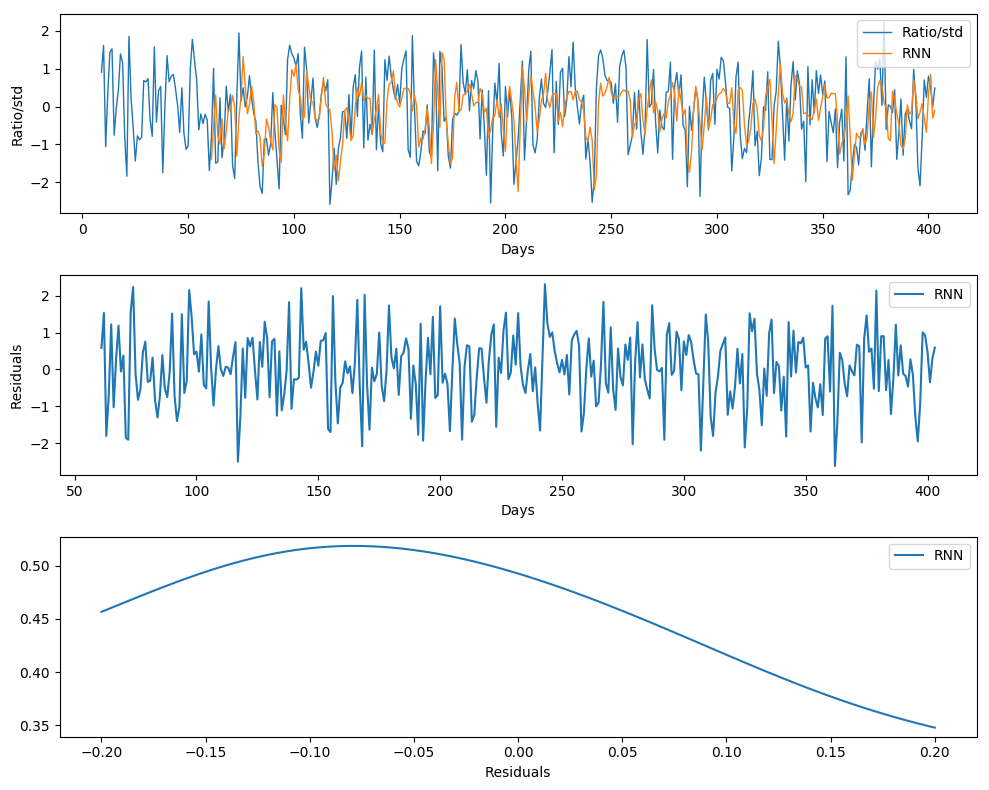

In [532]:
train_data = rnn.rolling_estimate(train_data)
plot_ratioFitting(results=train_data)

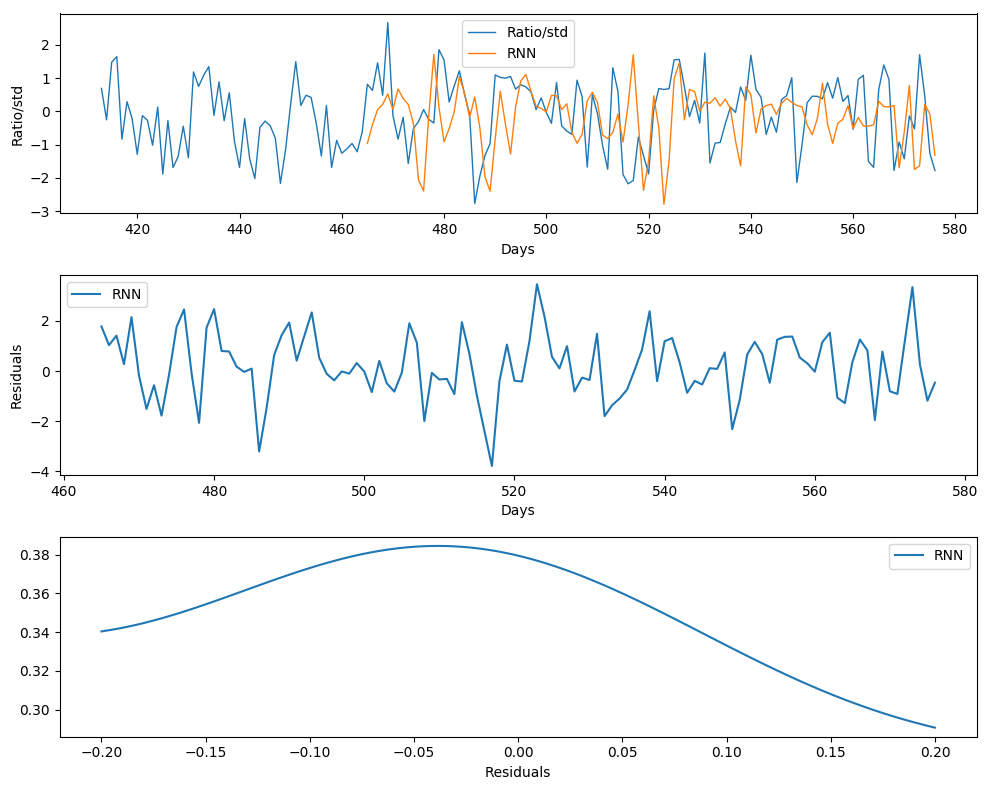

In [533]:
test_data = rnn.rolling_estimate(test_data)
plot_ratioFitting(results=test_data)

Fitting the ratio/std curve does not work that well. Even the overfitted train data is not really a good fit since the fit is "shifted" by one unit. This is therefore not a good strategy and it was abandoned.

## Position classification RNN strategy: 

This strategy defines entry and exit points based on a classification RNN algorithm trained to predict the position (either long ABC, short XYZ or short ABC, long XYZ) that result in the best profits.

First, we need to identify the best positions (looking at the future) in order to know how to train the network (find the labels). 

Following the threshold entry and exit strategy,  we identified all entry points for which ABC goes up and XYZ goes down or viceversa. Exit points are all other days that are not entry points. Before training the RNN, we can see how well this "perfect" strategy works:

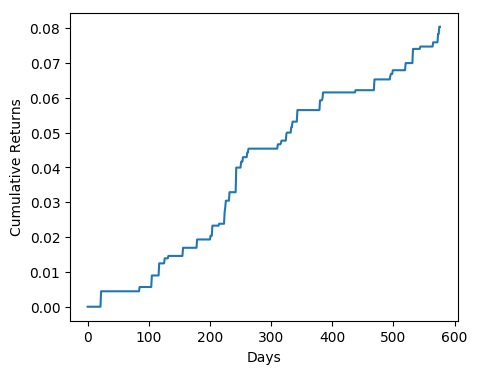

Expected AR is 2.66% +- 0.94% (1-sigma confidence)


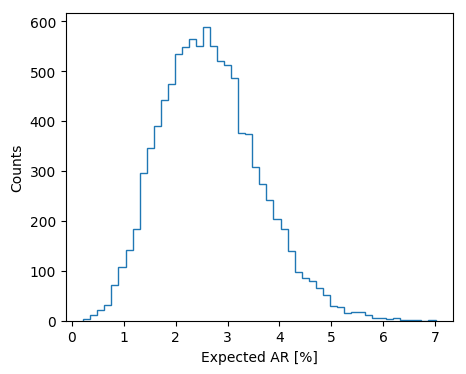

In [358]:
bestPairs_str = bestPairsStrategy()
bestPairs_str.apply()
bestPairs_str.plot() 
bestPairs_str.ARdistribution()

The expected AR of this strategy is actually worse than the best result using the threshold entry and exit strategy. Although, this result may seem counter intuitive there are two reasons for this:

- There are some situations in which the hedging does not fully work (since the ratio XYZ/ABC has a downward tendency) and therefore being long on ABC and short on XYZ (instead of neutral) is actually better in the long term.

- More importantly, if the rolling mean of the ratio XYZ/ABC jumps up, it does not mean necessarily that XYZ will move down and ABC will move up. It could also be that only one of them moves in the "right" direction while the other one stays close to neutral. In that case keeping the previous position will still net a positive daily return. Since the threshold entry and exit strategy stays in the previous position until an exit signal is triggered, the threshold basic strategy benefits from this. 

Based on the above observations, we can simply find the best possible position every day (again looking into the future) in a pair trading strategy regardless of how the individual components (ABC or XYZ) move. The position that nets a positive return the next day is selected for that day. This strategy will result in the best possible return with the given test data:

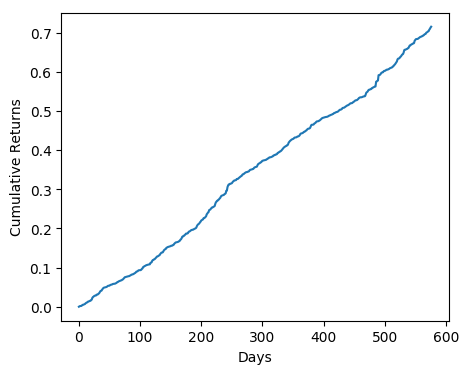

Expected AR is 23.88% +- 2.47% (1-sigma confidence)


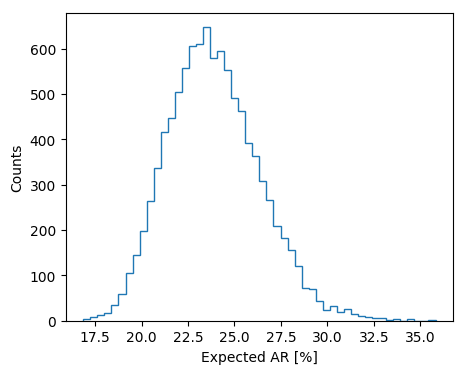

In [359]:
bestPositions_str = bestPositionsStrategy()
bestPositions_str.apply()
bestPositions_str.plot() 
bestPositions_str.ARdistribution()

The best possible AR on the test data using a pair strategy is 23.9%. This AR corresponds to the ceiling of what is possible in a pair traiding strategy. These positions are defined as the ideal positions and will be used as the labels to train all remaining algorithms.

Now that the target labels (best positions) have been defined, we can train an RNN algorithm using a single layer. The input data will be XYZ, ABC, DIFF and RATIO. The sequence length will be a hyper-parameter. The algorithm is trained with the first 70% of the data:

In [1124]:
train_data = seriesFull.loc[:len(seriesFull)*0.7]
train_data = bestPositions(train_data)
rnnCl = RNNClassification(n_neurons=20, learning_rate=0.001, fit_range=20)
rnnCl.fit(train_data, max_iterations=10000)

Iter 0 - model acc_train:0.5224 - model acc_validation:0.4522 - best acc_validation:0.4522
Iter 0 - model acc_train:0.5224 - model acc_validation:0.4522 - best acc_validation:0.4522
Iter 22 - model acc_train:0.5224 - model acc_validation:0.4609 - best acc_validation:0.4609
Iter 24 - model acc_train:0.4776 - model acc_validation:0.4870 - best acc_validation:0.4870
Iter 25 - model acc_train:0.4776 - model acc_validation:0.5130 - best acc_validation:0.5130
Iter 26 - model acc_train:0.4776 - model acc_validation:0.5478 - best acc_validation:0.5478
Iter 500 - model acc_train:0.5597 - model acc_validation:0.5217 - best acc_validation:0.5478
Iter 727 - model acc_train:0.5709 - model acc_validation:0.5565 - best acc_validation:0.5565
Iter 730 - model acc_train:0.5224 - model acc_validation:0.5652 - best acc_validation:0.5652
Iter 739 - model acc_train:0.5634 - model acc_validation:0.6000 - best acc_validation:0.6000
Iter 740 - model acc_train:0.5448 - model acc_validation:0.6261 - best acc_val

RNNClassification(fit_range=20, learning_rate=0.001, n_neurons=20,
         optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>)

In [1125]:
#rnnCl.save("../models/RNNClassification-best")

Hyper-parameter optimization can be also be done:

In [1077]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
     "n_neurons": [10, 20, 30, 50],
     "fit_range": [5, 10, 20],
     "learning_rate": [0.001, 0.01]
}

rnd_search = RandomizedSearchCV(RNNClassification(), param_distribs, n_iter=24,
                                random_state=42, verbose=2, cv=3, n_jobs=-1, 
                                iid=False)
rnd_search.fit(train_data, max_iterations=10000)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 24.0min finished


Iter 0 - model acc_train:0.5018 - model acc_validation:0.4661 - best acc_validation:0.4661
Iter 0 - model acc_train:0.5018 - model acc_validation:0.4661 - best acc_validation:0.4661
Iter 9 - model acc_train:0.5018 - model acc_validation:0.4831 - best acc_validation:0.4831
Iter 10 - model acc_train:0.5091 - model acc_validation:0.5000 - best acc_validation:0.5000
Iter 11 - model acc_train:0.5055 - model acc_validation:0.5339 - best acc_validation:0.5339
Iter 33 - model acc_train:0.5091 - model acc_validation:0.5508 - best acc_validation:0.5508
Iter 61 - model acc_train:0.5091 - model acc_validation:0.5593 - best acc_validation:0.5593
Iter 118 - model acc_train:0.5673 - model acc_validation:0.5678 - best acc_validation:0.5678
Iter 500 - model acc_train:0.5927 - model acc_validation:0.4831 - best acc_validation:0.5678
Iter 1000 - model acc_train:0.6218 - model acc_validation:0.4831 - best acc_validation:0.5678
Iter 1340 - model acc_train:0.6145 - model acc_validation:0.6695 - best acc_val

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RNNClassification(fit_range=50, learning_rate=0.01, n_neurons=10,
         optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>),
          fit_params=None, iid=False, n_iter=24, n_jobs=-1,
          param_distributions={'n_neurons': [10, 20, 30, 50], 'fit_range': [5, 10, 20], 'learning_rate': [0.001, 0.01]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [1078]:
rnd_search.best_params_

{'n_neurons': 50, 'learning_rate': 0.001, 'fit_range': 10}

An strategy following the positions calculated by the trained RNN algorithm results in:

INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best


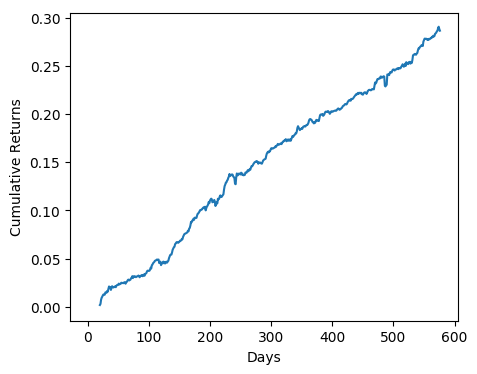

Expected AR is 10.45% +- 2.74% (1-sigma confidence)


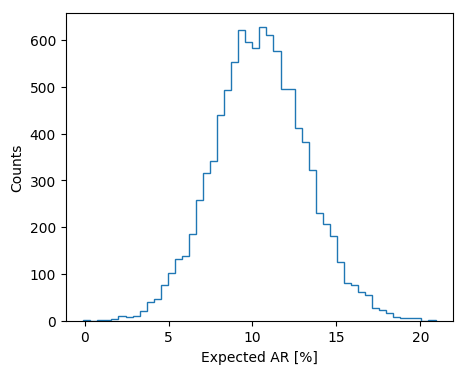

In [360]:
RNNCl_str = RNNClStrategy()
RNNCl_str.apply(threshold = 0.5)
RNNCl_str.plot() 
RNNCl_str.ARdistribution()

This method can certainly benefit from more data. The number of neurons in the single layer is low because the algorithm overfits the training data otherwise. The best result of the grid search was not used at the end because of the problem of overfitting. It is worth to point out that it is better to have a position than to be neutral in a given day. Since the RNN classifier uses a softmax classifier, the probabilities of belonging to a given position can be used to define either an entry point or to remain neutral (by using a threshold). Raising the threshold above asimple majority decreases the AR.

## Position classification LSTM strategy:

This strategy defines entry and exit points based on a classification LSTM algorithm trained to predict the position that results in the best profits. The LSTM is trained using a single layer. The input data consists of XYZ, ABC, DIFF and RATIO. The sequence length is be a hyper-parameter. The algorithm is trained with the first 70% of the data:

In [1135]:
train_data = seriesFull.loc[:len(seriesFull)*0.7]
train_data = bestPositions(train_data)
lstmCl = LSTMClassification(n_neurons=5, learning_rate=0.001, fit_range=20)
lstmCl.fit(train_data, max_iterations=5000)

Iter 0 - model acc_train:0.4776 - model acc_validation:0.5478 - best acc_validation:0.5478
Iter 0 - model acc_train:0.4776 - model acc_validation:0.5478 - best acc_validation:0.5478
Iter 500 - model acc_train:0.4776 - model acc_validation:0.5478 - best acc_validation:0.5478
Iter 1000 - model acc_train:0.5224 - model acc_validation:0.4522 - best acc_validation:0.5478
Iter 1500 - model acc_train:0.5224 - model acc_validation:0.4522 - best acc_validation:0.5478
Iter 1926 - model acc_train:0.5522 - model acc_validation:0.5565 - best acc_validation:0.5565
Iter 1930 - model acc_train:0.5522 - model acc_validation:0.5739 - best acc_validation:0.5739
Iter 2000 - model acc_train:0.5560 - model acc_validation:0.5391 - best acc_validation:0.5739
Iter 2167 - model acc_train:0.5784 - model acc_validation:0.5913 - best acc_validation:0.5913
Iter 2242 - model acc_train:0.5896 - model acc_validation:0.6087 - best acc_validation:0.6087
Iter 2262 - model acc_train:0.5933 - model acc_validation:0.6174 - 

LSTMClassification(fit_range=20, learning_rate=0.001, n_layers=None,
          n_neurons=5,
          optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>)

In [1136]:
#lstmCl.save("../models/LSTMClassification-best")

The strategy that uses the positions predicted by the trained LSTM algorithm is:

INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best


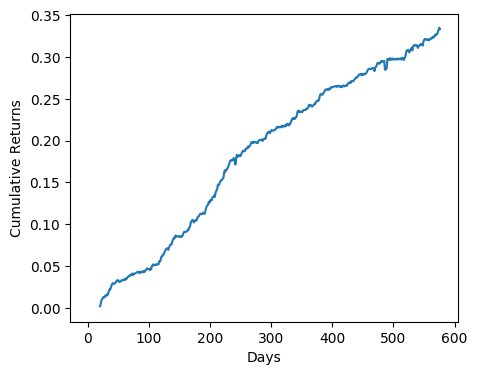

Expected AR is 8.16% +- 2.74% (1-sigma confidence)


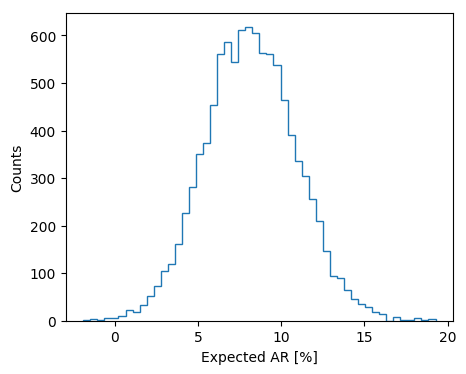

In [366]:
LSTMCl_str = LSTMClStrategy()
LSTMCl_str.apply(threshold = 0.5)
LSTMCl_str.plot() 
LSTMCl_str.ARdistribution()

This method will certainly benefit from more data as well. The number of neurons in the single layer is already low (5 neurons) because the algorithm overfits the training data otherwise. As with the RNN strategy, it is better to have a position than be neutral. Raising the threshold above simple majority in the softmax probabilities decreases the test data AR.

## Position classification by a combination of logistic regression, random forest and K-neighbors strategy:

This strategy defines entry and exit points based on a hard voting classifier ensemble of random forest, logistic regression and k-neighbor algorithms trained to predict the position that results in the best profits. The input data is XYZ, ABC, DIFF and RATIO given over a set number of days. The number of days is a hyper-parameter that has been optimized. Hyper-parameters in each model were also optimized. 

In [159]:
train_data = seriesFull.loc[:len(seriesFull)*0.7]
train_data = bestPositions(train_data)
fit_data = 10 # Number of days
classif = trainClassification(train_data, fit_data)

 Model LogisticRegression - acc. train set: 0.6983 - acc. validation set: 0.6465
 Model RandomForestClassifier - acc. train set: 0.7864 - acc. validation set: 0.6061
 Model KNeighborsClassifier - acc. train set: 0.6271 - acc. validation set: 0.4848
 Model VotingClassifier - acc. train set: 0.7729 - acc. validation set: 0.6364


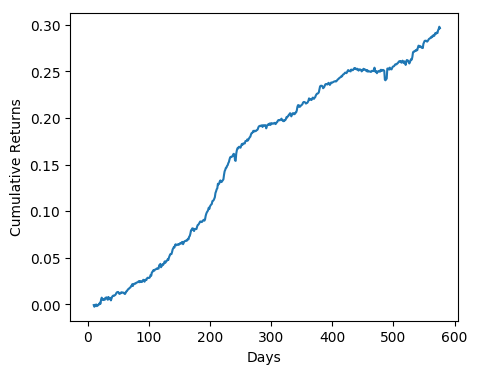

Expected AR is 6.98% +- 2.71% (1-sigma confidence)


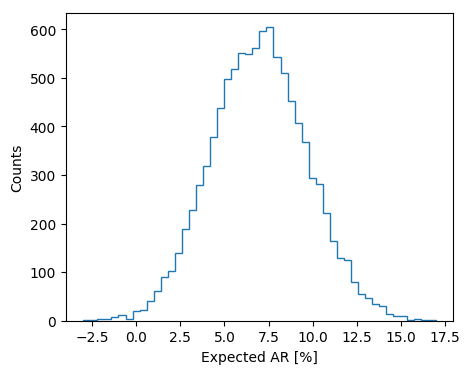

In [363]:
Classif_str = classifStrategy()
Classif_str.apply(classif)
Classif_str.plot() 
Classif_str.ARdistribution()

This method will certainly benefit from more data as well. Some of the hyper-parameters in the random forest method are pretty low (max_depth = 3, min_samples_leaf = 15) already.  The K-neighbor hyper-parameters were optimized but did not make much difference in terms of improvement. Algorithms SVC and Gaussian Processes classifier were also used but their results were significantly worse than the algorithms selected.

## Ensemble strategy:
An strategy that combines the optimized strategies discussed earlier into a hard voting ensemble were studied. Different combinations of the threshold entry and exit, random forest, logistic regression, RNN and LSTM strategies into the ensemble were studied. If there is a tie, a position long on ABC and short on XYZ was chosen since it is better than to be neutral. 

In [161]:
all_data = bestPositions(seriesFull)
train_data = all_data.loc[:len(all_data)*0.7]
test_data = all_data.loc[len(all_data)*0.7:]

All the methods in the ensemble have already been trained (using only the first 70% of the data) and are saved to disk. In case they need to be trained again the following method can be used. The RNN and LSTM algorithms take longer to train and therefore they are optional (the saving option is also disabled for now). 

In [162]:
trainModelsEnsemble(train_data, fit_RNN = False, fit_LSTM = False)

The accuracy between the ideal pair strategy positions and predicted positions for the different algorithms in unseen data is the following: 

In [163]:
checkAccuracy(test_data, ensemblePositions(test_data) )

INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best
LogisticRegression accuracy: 0.5882352941176471
RandomForest accuracy: 0.6143790849673203
RNN accuracy: 0.6405228758169934
LSTM accuracy: 0.6470588235294118
BasicStrategy accuracy: 0.5098039215686274
Ensemble accuracy: 0.5816993464052288
IdealPosition accuracy: 1.0


Based on the accuracy selecting the positions, the best algorithms are RNN and LSTM. The following methods define and apply the strategy. The apply method has the option of selecting the algorithm of choice between *BasicStrategy* (threshold entry and exit), *RandomForest*, *LogisticRegression*, *RNN*, *LSTM* and *Ensemble*. Using only the RNN and LSTM algorithms in the ensemble strategy results in:

INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best


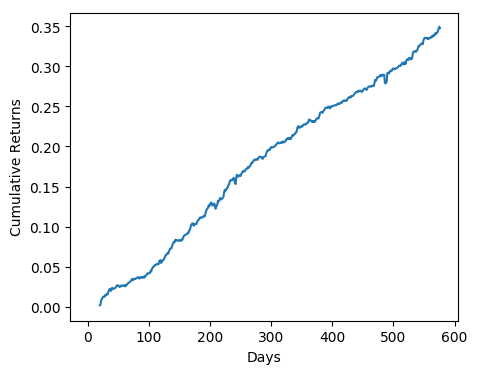

Expected AR is 11.67% +- 2.72% (1-sigma confidence)


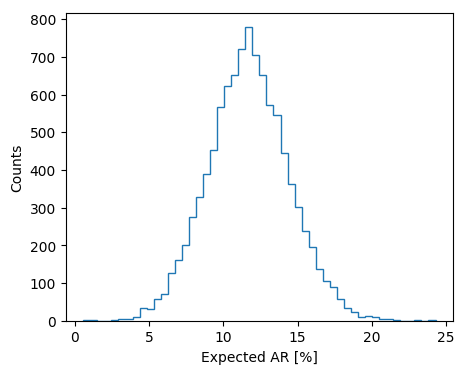

In [383]:
ensemble_str = ensembleStrategy(seriesFull)
ensemble_str.apply(model = 'Ensemble', includeRF = True)
ensemble_str.plot() 
ensemble_str.ARdistribution()

## Summary:
The expected AR and risk (defined as the AR 1-sigma confidence) for the different strategies considered here are shown:

INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best
INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best
INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best
INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best


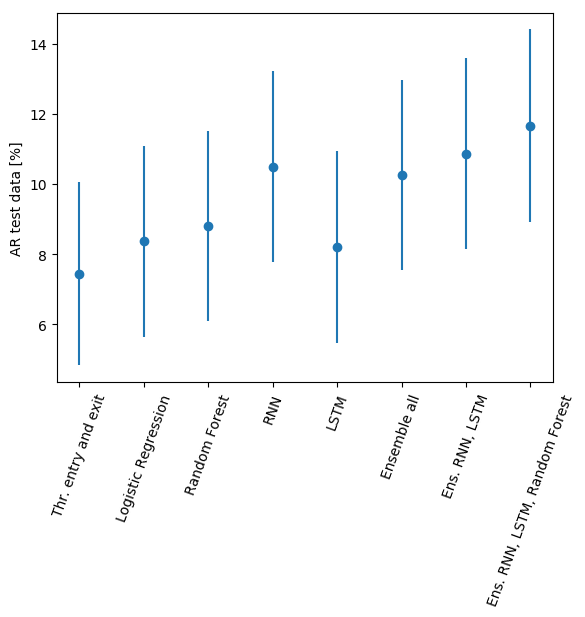

In [382]:
summary(ensemble_str)

A hard voting ensemble considering only the RNN and LSTM strategies is slightly better than other strategies. The uncertainty in the predicted AR (or risk) is due to the limited number of days in the test data set and it only represents the *statistical* uncertainty. The associated risk does not include the uncertainty due to changes in the behavior of the ABC and XYZ which may be significant if the algorithms are not trained to capture such a change. It is recommended that if the correlated behavior of ABC and XYZ is expected to change over a time period of *N* number of days, the algorithms be trained in a shorter time scale. In the case considered here, the training of the algorithms can be done every few weeks. 

#### Comment about the code:
Running of the preferred trained model to obtain a new prediction is rather simple:
```python
seriesFull = pd.read_csv('../data/raw/pairs.csv', header=0) 
ensemble_str = ensembleStrategy(seriesFull)
ensemble_str.apply(model = 'Ensemble')
ensemble_str.print()
```
The final row will have the predicted position (1 for long ABC, short XYZ and -1 for short ABC, long ABC). 

To train the models, the code is simply:
```python
trainModelsEnsemble(train_data, fit_RNN = True, fit_LSTM = True) 
            # train_data has the same format as pairs.csv
```

# Capital allocation
As discussed earlier, the best investment strategy uses the fact that it is better to pick a position than to be neutral in the long term. As such, one expects that the best capital allocation strategy will also require to invest all initial capital at the earliest opportunity. This capital allocation strategy was verified by a Monte Carlo simulation were the $10 million were allocated daily in equal amounts until all the money had been invested. The investment portafolio after 1 year as a function of days to allocate is shown bellow:

INFO:tensorflow:Restoring parameters from ../models/RNNClassification-best
INFO:tensorflow:Restoring parameters from ../models/LSTMClassification-best


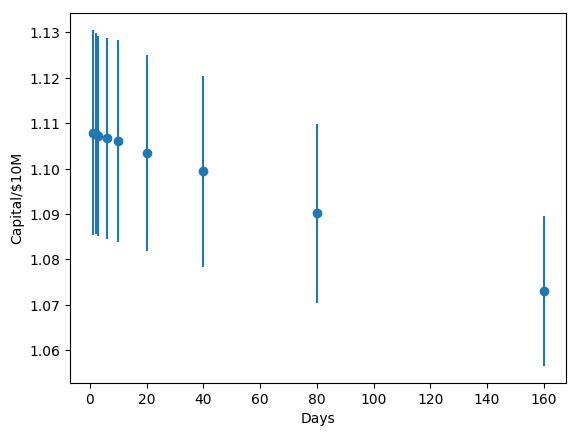

In [322]:
constantAllocationPlot(seriesFull)

# Scaling
The final code is not ready for production. It is not prepared for version control nor for parallelization either by Multithreading or Multiprocessing (except by using the Scikit-Learn RandomizedSearchCV parallelization option or by native sklearn algorithms). The code could be made faster by creating vectorized functions, by using the python multiprocessing library (for example when searching the best hyper-parameters of the models) and by distributing TensorFlow computations among several CPUs or GPUs using the distributed tensorflow framework. If the same model needs to be applied in sequence (for example if the same strategy is to be used in several times per second) TensorFlow Queues may be advantageous and could be implemented.    

Assuming access to a large cloud provider like Google Cloud Platform, AWS, Azure Machine Learning Studio or Kubeflow, it may possible to use distributed analytic frameworks such as Hadoop MapReduce. In this particular pair strategy scenario, a combination of TensorFlow Serving and Kubernetes can be used to deploy as a web server to communicate with a python script by a REST API. In the case of several thousands of strategies being deployed simultaneously it would be relatively easy to parallelize a pipeline of importing data from an SQL database, running the trained model and exporting the results back to the database. I would recommend offline learning for the pair strategy implementation. How often the models will need to be trained will need to be tested. I would recommend to initially train them once per week and if possible once per day and adjust as necessary. Model version control can be done by storing the trained model in the cloud server like Amazon S3 and all the reproducible codes in Git. An alternative may be to use a DVC system. 

